In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os
import logging
import math
import re
import json

In [346]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [347]:
PATH_TO_CSVS = 'data/raw'
RANDOM_STATE = 1

In [348]:
# https://stackoverflow.com/questions/46135839/auto-detect-the-delimiter-in-a-csv-file-using-pd-read-csv comme base
# detecte automatiquement le sep d'un fichier csv


def get_delimiter(file_path, bytes=4096):
    try:
        with open(file_path, 'r') as file:
            data = file.read(bytes)
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(data).delimiter
        return delimiter
    except Exception as e:
        logging.error(f"Erreur lors de la détection du délimiteur: {e}")
        return None

In [349]:
# lecture d'un fichier csv en essayant différents encodage.


def read_csv_file(file_path):
    if not os.path.exists(file_path):
        return None, False, f"Fichier non trouvé: {file_path}"
    
    delimiter = get_delimiter(file_path)
    if not delimiter:
        return None, False, f"Impossible de détecter le délimiteur pour le fichier: {file_path}"
    
    encodings = ['utf-8', 'latin1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, low_memory=False, encoding=encoding, delimiter=delimiter)
            return df, True, None
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            logging.warning(f"Erreur avec l'encodage {encoding} pour le fichier {file_path}: {e}")
    
    return None, False, f"Impossible de lire le fichier {file_path} avec les encodages: {encodings}."

    #modification github

In [350]:
# chargement des datasets dans des listes
# La fonction load_datasets charge des jeux de données à partir de fichiers CSV selon des préfixes et des années spécifiés. Les fichiers sont chargés dans une structure de listes de dictionnaires.


def load_datasets(prefixes, years, base_path= PATH_TO_CSVS):
    dataframes = []
    
    for prefix in prefixes:
        datasets = []
        for year in years:
            connector = '_' if year <= 2016 else '-'
            file_name = os.path.join(base_path, f'{prefix}{connector}{year}.csv')
            df, success, error = read_csv_file(file_name)
            if success:
                datasets.append({file_name: df})
            else:
                logging.error(error)
        dataframes.append(datasets)
    
    return dataframes

In [351]:
years = list(range(2019, 2023))
prefixes= ['caracteristiques', 'lieux', 'usagers', 'vehicules']

dataframes = load_datasets(prefixes, years)

# log
for prefix, df_list in zip(prefixes, dataframes):
        logging.info(f'{prefix}: {len(df_list)} datasets chargés.')

logging.info(f'Total datasets chargés: {sum(len(dfs) for dfs in dataframes)}.')

2024-06-30 10:35:08,917 - INFO - caracteristiques: 4 datasets chargés.
2024-06-30 10:35:08,917 - INFO - lieux: 4 datasets chargés.
2024-06-30 10:35:08,917 - INFO - usagers: 4 datasets chargés.
2024-06-30 10:35:08,917 - INFO - vehicules: 4 datasets chargés.
2024-06-30 10:35:08,931 - INFO - Total datasets chargés: 16.


In [352]:
# Convertir les dtypes d'un dataframe
# La fonction convert_dtypes convertit les types de données des colonnes d'un DataFrame selon une structure de référence.


def convert_dtypes(df, reference_dtypes):
    for col in df.columns:
        if col in reference_dtypes:
            try:
                df.loc[:, col] = df[col].astype(reference_dtypes[col])  # Utilisation de .loc pour éviter les warnings.
            except ValueError as e:
                logging.error(f"Erreur lors de la conversion de la colonne {col} en type {reference_dtypes[col]}: {e}")
    return df

In [353]:
# Extraire la structure de référence de chaque groupe de dataframes
# La fonction extract_reference_structure extrait les structures de référence (types de données des colonnes) des derniers fichiers chargés pour chaque préfixe.


def extract_reference_structure(dataframes):
    reference_structures = {}
    
    for prefix, df_list in zip(prefixes, dataframes):
        if df_list:
            last_df = list(df_list[-1].values())[0]
            reference_structures[prefix] = last_df.dtypes.to_dict()
    return reference_structures

In [354]:
# Gérer le préprocessing
# La fonction preprocess effectue diverses opérations de prétraitement sur les DataFrames selon des règles spécifiques à chaque type de fichier (caractéristiques, lieux, usagers, véhicules).
# La fonction preprocess_datasets applique le prétraitement à tous les datasets chargés.


def preprocess(df, prefix):
    if prefix == 'caracteristiques':
        # Renommer 'Accident_Id' en 'Num_Acc' si nécessaire
        if 'Accident_Id' in df.columns:
            df = df.rename(columns={'Accident_Id': 'Num_Acc'})

        # Ajouter 2000 à 'an' si < 2000
        if 'an' in df.columns:
            df.loc[:, 'an'] = df['an'].apply(lambda x: x + 2000 if x < 2000 else x)
        
        # Convertir 'hrmn' de 'HHMM' à 'HH:MM'
        if 'hrmn' in df.columns:
            df.loc[:, 'hrmn'] = df['hrmn'].apply(lambda x: f"{str(x).zfill(4)[:2]}:{str(x).zfill(4)[2:]}")
        
        # Remplacer les valeurs NaN par -1
        for col in ['lum', 'int', 'atm', 'col']:
            if col in df.columns:
                df[col] = df[col].fillna(-1)
        
        # Supprimer les colonnes 'adr', 'lat', 'long'
        df = df.drop(columns=['adr', 'lat', 'long'], errors='ignore')

    elif prefix == 'lieux':
        # Remplacer les valeurs NaN par -1
        for col in ['circ', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'surf', 'infra', 'situ']:
            if col in df.columns:
                df[col] = df[col].fillna(-1)
        
        # Remplacer les valeurs NaN et 0 par -1 pour 'lartpc'
        if 'lartpc' in df.columns:
            df['lartpc'] = df['lartpc'].replace(0, -1).fillna(-1)
        
        # Remplacer les valeurs NaN et > 130 par -1 pour 'vma'
        if 'vma' in df.columns:
            df['vma'] = df['vma'].apply(lambda x: -1 if pd.isna(x) or x > 130 else x)
        
        # Supprimer les colonnes 'voie', 'v1', 'v2', 'larrout'
        df = df.drop(columns=['voie', 'v1', 'v2', 'larrout'], errors='ignore')

    elif prefix == 'usagers':
        # Remplacer les valeurs NaN par -1
        for col in ['place', 'catu', 'grav', 'sexe', 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp']:
            if col in df.columns:
                df[col] = df[col].fillna(-1)
        
        # Remplacer les valeurs 4 par -1 pour 'catu'
        if 'catu' in df.columns:
            df['catu'] = df['catu'].replace(4, -1)
        
        # Gérer les outliers pour 'an_nais'
        if 'an_nais' in df.columns:
            df['an_nais'] = df['an_nais'].apply(lambda x: pd.NA if x < 1900 else x)
    
    elif prefix == 'vehicules':
        # Remplacer les valeurs NaN par -1
        for col in ['senc', 'obs', 'obsm', 'choc', 'manv', 'motor']:
            if col in df.columns:
                df[col] = df[col].fillna(-1)
        
        # Remplacer les valeurs NaN par 0 pour 'catv'
        if 'catv' in df.columns:
            df['catv'] = df['catv'].fillna(0)
        
        # Supprimer la colonne 'occutc'
        df = df.drop(columns=['occutc'], errors='ignore')
    
        for col in df.columns:
            if df[col].dtype == np.float64 or df[col].dtype == np.int64:
                df.loc[:, col] = df[col].fillna(-1)

        # Gestion des cas particuliers
        if 'lartpc' in df.columns:
            df.loc[:, 'lartpc'] = df['lartpc'].replace(0, -1).fillna(-1)
        if 'catu' in df.columns:
            df.loc[:, 'catu'] = df['catu'].replace(4, -1)
        if 'an_nais' in df.columns:
            df.loc[:, 'an_nais'] = df['an_nais'].apply(lambda x: pd.NA if x < 1900 else x)
        
    return df
    


In [355]:
# appliquer preprocess sur tous les datasets


def preprocess_datasets(dataframes):
    for prefix, df_list in zip(prefixes, dataframes):
        for df_dict in df_list:
            for file_name, df in df_dict.items():
                df = preprocess(df, prefix)
                df_dict[file_name] = df
    return dataframes

In [356]:
# Harmoniser les autres dataframes selon la structure de référence
# La fonction harmonize_dataframes harmonise les DataFrames selon les structures de référence, en conservant uniquement les colonnes présentes dans la structure de référence et en convertissant les types de données.


def harmonize_dataframes(dataframes, reference_structures):
    harmonized_dataframes = []
    
    for prefix, df_list in zip(prefixes, dataframes):
        reference_dtypes = reference_structures.get(prefix, {})
        harmonized_group = []
        
        for df_dict in df_list:
            for file_name, df in df_dict.items():
                # Garder uniquement les colonnes présentes dans la structure de référence
                df = df[[col for col in df.columns if col in reference_dtypes]]
                
                # Convertir les données
                df = convert_dtypes(df, reference_dtypes)
                
                harmonized_group.append({file_name: df})
        
        harmonized_dataframes.append(harmonized_group)
    
    return harmonized_dataframes


In [357]:
# Changements à prévoir

# Structure de référence pour caractéristiques: {
# 'Num_Acc': dtype('int64'), -> changer Accident_Id du dernier dataframe
# 'jour': dtype('int64'), -> OK
#  'mois': dtype('int64'), -> OK
# 'an': dtype('int64'), -> +2000 si <2000
# 'hrmn': dtype('O'), -> il faut traiter le changement de HHMM à HH:MM
# 'lum': dtype('int64'), -> N/A to -1
#  'dep': dtype('O'), -> la saisie change en 2019
# 'com': dtype('O'), -> changement de saisie
# 'agg': dtype('int64'), -> rien à gérer
#  'int': dtype('int64'), -> N/A to -1
#  'atm': dtype('int64'), -> N/A to -1
#  'col': dtype('int64'), -> N/A to -1
#  'adr': dtype('O'), -> à supprimer
#  'lat': dtype('O'), -> à supprimer
#  'long': dtype('O')} -> à supprimer

# Structure de référence pour lieux: {
# 'Num_Acc': dtype('int64'),
#  'catr': dtype('int64'), -> ok
#  'voie': dtype('O'), -> à supprimer
#  'v1': dtype('int64'), -> à supprimer
#  'v2': dtype('O'), -> à supprimer
#  'circ': dtype('int64'), -> N/A to -1
#  'nbv': dtype('O'), -> Abhérations à gérer
#  'vosp': dtype('int64'), -> N/A to -1
#  'prof': dtype('int64'), -> N/A to -1
#  'pr': dtype('O'), -> N/A to -1
#  'pr1': dtype('O'), -> N/A to -1
#  'plan': dtype('int64'), -> N/A to -1
#  'lartpc': dtype('O'), -> N/A and 0 to -1
#  'larrout': dtype('O'), -> à supprimer
#  'surf': dtype('int64'), -> N/A to -1
#  'infra': dtype('int64'), -> N/A to -1
#  'situ': dtype('int64'), -> N/A to -1
#  'vma': dtype('int64')} -> Si > 130 alors -1 et N/A to -1

# Structure de référence pour usagers: {
# 'Num_Acc': dtype('int64'),
#  'id_usager': dtype('O'), 
#  'id_vehicule': dtype('O'), 
#  'num_veh': dtype('O'), 
#  'place': dtype('int64'), N/A to -1
#  'catu': dtype('int64'), N/A and 4 to -1
#  'grav': dtype('int64'), N/A to -1
#  'sexe': dtype('int64'), -> N/A to -1
#  'an_nais': dtype('float64'), Attention aux outliers très bas.
#  'trajet': dtype('int64'), N/A to -1
#  'secu1': dtype('int64'), N/A to -1
#  'secu2': dtype('int64'), N/A to -1
#  'secu3': dtype('int64'), N/A to -1
#  'locp': dtype('int64'), N/A to -1 
#  'actp': dtype('O'), N/A to -1
#  'etatp': dtype('int64')} N/A to -1

# Structure de référence pour vehicules: {
# 'Num_Acc': dtype('int64'),
#  'id_vehicule': dtype('O'),
#  'num_veh': dtype('O'), 
#  'senc': dtype('int64'), N/A to -1
#  'catv': dtype('int64'), N/A to 0
#  'obs': dtype('int64'), N/A to -1
#  'obsm': dtype('int64'), N/A to -1
#  'choc': dtype('int64'), N/A to -1
#  'manv': dtype('int64'), N/A to -1
#  'motor': dtype('int64'), N/A to -1
#  'occutc': dtype('float64')} à supprimer

In [358]:
dataframes = preprocess_datasets(dataframes)
reference_structures = extract_reference_structure(dataframes)
harmonized_dataframes = harmonize_dataframes(dataframes, reference_structures)

In [359]:
for prefix, df_list in zip(prefixes, harmonized_dataframes):
    logging.info(f'{prefix}: {len(df_list)} datasets harmonisés.')

logging.info(f'Total datasets harmonisés: {sum(len(dfs) for dfs in harmonized_dataframes)}.')

2024-06-30 10:35:09,887 - INFO - caracteristiques: 4 datasets harmonisés.
2024-06-30 10:35:09,887 - INFO - lieux: 4 datasets harmonisés.
2024-06-30 10:35:09,887 - INFO - usagers: 4 datasets harmonisés.
2024-06-30 10:35:09,898 - INFO - vehicules: 4 datasets harmonisés.
2024-06-30 10:35:09,899 - INFO - Total datasets harmonisés: 16.


In [360]:
# Afficher les structures de référence pour vérification


for prefix, structure in reference_structures.items():
    logging.info(f'Structure de référence pour {prefix}: {structure}')

2024-06-30 10:35:09,908 - INFO - Structure de référence pour caracteristiques: {'Num_Acc': dtype('int64'), 'jour': dtype('int64'), 'mois': dtype('int64'), 'an': dtype('int64'), 'hrmn': dtype('O'), 'lum': dtype('int64'), 'dep': dtype('O'), 'com': dtype('O'), 'agg': dtype('int64'), 'int': dtype('int64'), 'atm': dtype('int64'), 'col': dtype('int64')}
2024-06-30 10:35:09,914 - INFO - Structure de référence pour lieux: {'Num_Acc': dtype('int64'), 'catr': dtype('int64'), 'circ': dtype('int64'), 'nbv': dtype('O'), 'vosp': dtype('int64'), 'prof': dtype('int64'), 'pr': dtype('O'), 'pr1': dtype('O'), 'plan': dtype('int64'), 'lartpc': dtype('O'), 'surf': dtype('int64'), 'infra': dtype('int64'), 'situ': dtype('int64'), 'vma': dtype('int64')}
2024-06-30 10:35:09,915 - INFO - Structure de référence pour usagers: {'Num_Acc': dtype('int64'), 'id_usager': dtype('O'), 'id_vehicule': dtype('O'), 'num_veh': dtype('O'), 'place': dtype('int64'), 'catu': dtype('int64'), 'grav': dtype('int64'), 'sexe': dtype(

In [361]:
# Comparer structure réelles et référence
# La fonction compare_structures compare les structures des DataFrames harmonisés avec les structures de référence et enregistre les différences.


def compare_structures(harmonized_dataframes, reference_structures):
    for prefix, df_list in zip(prefixes, harmonized_dataframes):
        reference_dtypes = reference_structures.get(prefix, {})
        for df_dict in df_list:
            for file_name, df in df_dict.items():
                df_dtypes = df.dtypes.to_dict()
                missing_cols = set(reference_dtypes.keys()) - set(df_dtypes.keys())
                extra_cols = set(df_dtypes.keys()) - set(reference_dtypes.keys())
                diff_types = {col: (reference_dtypes[col], df_dtypes[col]) for col in df_dtypes if col in reference_dtypes and reference_dtypes[col] != df_dtypes[col]}

                table_data = [
                    ["Colonnes manquantes", ", ".join(missing_cols)],
                    ["Colonnes supplémentaires", ", ".join(extra_cols)],
                    ["Différences de types", ", ".join([f"{col} (réf: {reference_dtypes[col]}, fichier: {df_dtypes[col]})" for col in diff_types])]
                ]
                table = tabulate(table_data, headers=["Type de différence", "Colonnes"], tablefmt="grid")
                
                logging.info(f"Comparaison pour le fichier {file_name}:\n{table}")

In [362]:
compare_structures(harmonized_dataframes, reference_structures)

2024-06-30 10:35:09,936 - INFO - Comparaison pour le fichier data/raw\caracteristiques-2019.csv:
+--------------------------+------------+
| Type de différence       | Colonnes   |
+==========================+============+
| Colonnes manquantes      |            |
+--------------------------+------------+
| Colonnes supplémentaires |            |
+--------------------------+------------+
| Différences de types     |            |
+--------------------------+------------+
2024-06-30 10:35:09,936 - INFO - Comparaison pour le fichier data/raw\caracteristiques-2020.csv:
+--------------------------+------------+
| Type de différence       | Colonnes   |
+==========================+============+
| Colonnes manquantes      |            |
+--------------------------+------------+
| Colonnes supplémentaires |            |
+--------------------------+------------+
| Différences de types     |            |
+--------------------------+------------+
2024-06-30 10:35:09,936 - INFO - Comparaison pour 

In [363]:
# Fonction pour concaténer les DataFrames par type
# La fonction concat_harmonized_dataframes concatène les DataFrames harmonisés de chaque groupe en un seul DataFrame par type.


def concat_harmonized_dataframes(dataframes):
    concatenated_dataframes = []

    for df_list in dataframes:
        
        df_only_list = [list(d.values())[0] for d in df_list]
        concatenated_df = pd.concat(df_only_list, ignore_index=True)
        concatenated_dataframes.append(concatenated_df)
    
    return concatenated_dataframes

In [364]:
for group in harmonized_dataframes:
    for df_dict in group:
        for file_name, df in df_dict.items():
            print(f"Head of harmonized dataframe {file_name}:")
            display(df.head())

Head of harmonized dataframe data/raw\caracteristiques-2019.csv:


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col
0,201900000001,30,11,2019,01::30,4,93,93053,1,1,1,2
1,201900000002,30,11,2019,02::50,3,93,93066,1,1,1,6
2,201900000003,28,11,2019,15::15,1,92,92036,1,1,1,4
3,201900000004,30,11,2019,20::20,5,94,94069,1,1,1,4
4,201900000005,30,11,2019,04::00,3,94,94028,1,1,1,2


Head of harmonized dataframe data/raw\caracteristiques-2020.csv:


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col
0,202000000001,7,3,2020,16::55,1,91,91657,2,3,1,3
1,202000000002,7,3,2020,08::35,2,91,91657,2,9,7,6
2,202000000003,7,3,2020,13::30,1,91,91174,2,2,1,3
3,202000000004,7,3,2020,18::50,5,91,91215,2,1,1,6
4,202000000005,7,3,2020,11::00,1,77,77181,1,6,1,2


Head of harmonized dataframe data/raw\caracteristiques-2021.csv:


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col
0,202100000001,30,11,2021,07::32,2,30,30319,1,1,1,1
1,202100000002,25,9,2021,14::20,1,51,51544,1,3,1,3
2,202100000003,15,7,2021,07::55,1,85,85048,2,1,7,6
3,202100000004,27,3,2021,19::45,5,93,93005,2,2,3,6
4,202100000005,25,2,2021,07::20,5,76,76429,2,1,1,2


Head of harmonized dataframe data/raw\caracteristiques-2022.csv:


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col
0,202200000001,19,10,2022,16::15,1,26,26198,2,3,1,3
1,202200000002,20,10,2022,08::34,1,25,25204,2,3,1,3
2,202200000003,20,10,2022,17::15,1,22,22360,2,6,1,2
3,202200000004,20,10,2022,18::00,1,16,16102,2,3,8,6
4,202200000005,19,10,2022,11::45,1,13,13103,1,1,1,2


Head of harmonized dataframe data/raw\lieux-2019.csv:


,Num_Acc,catr,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,surf,infra,situ,vma
0,201900000001,1,3,10,0,1,6,900,2,-1.0,1,2,1,70
1,201900000002,1,1,2,0,4,3,845,2,-1.0,1,0,1,70
2,201900000003,1,3,8,0,1,10,500,3,-1.0,1,0,1,90
3,201900000004,1,3,5,0,1,2,299,1,-1.0,1,0,1,90
4,201900000005,1,1,3,0,1,41,0,3,-1.0,1,2,1,90


Head of harmonized dataframe data/raw\lieux-2020.csv:


,Num_Acc,catr,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,surf,infra,situ,vma
0,202000000001,4,2,2,0,1,0,0,1,-1,1,0,1,50
1,202000000002,4,2,2,0,1,0,100,3,-1,1,0,1,50
2,202000000003,4,-1,2,0,1,0,0,1,-1,1,0,1,50
3,202000000004,4,2,2,0,1,1,0,1,-1,1,0,1,30
4,202000000005,3,1,1,0,1,4,674,2,-1,1,3,8,50


Head of harmonized dataframe data/raw\lieux-2021.csv:


,Num_Acc,catr,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,surf,infra,situ,vma
0,202100000001,3,2,2,0,1,(1),(1),1,-1,1,0,1,80
1,202100000002,3,2,2,0,1,0,10,1,-1,1,0,1,80
2,202100000003,4,2,2,0,1,(1),(1),1,-1,1,0,1,50
3,202100000004,3,2,4,0,1,0,1,1,-1,1,0,1,50
4,202100000005,7,2,2,-1,1,11,150,1,-1,1,0,1,50


Head of harmonized dataframe data/raw\lieux-2022.csv:


,Num_Acc,catr,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,surf,infra,situ,vma
0,202200000001,4,2,2,0,1,(1),(1),1,-1,1,0,1,50
1,202200000002,4,2,2,0,1,(1),(1),1,-1,1,0,1,50
2,202200000003,3,-1,2,0,1,0,0,1,-1,1,5,1,50
3,202200000004,4,1,1,0,2,(1),(1),1,-1,1,0,1,30
4,202200000005,3,2,2,0,1,8,0,1,-1,1,0,1,80


Head of harmonized dataframe data/raw\usagers-2019.csv:


,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,201900000001,138 306 524,B01,2,2,4,2,2002,0,1,0,-1,-1,-1,-1
1,201900000001,138 306 524,B01,1,1,4,2,1993,5,1,0,-1,-1,-1,-1
2,201900000001,138 306 525,A01,1,1,1,1,1959,0,1,0,-1,-1,-1,-1
3,201900000002,138 306 523,A01,1,1,4,2,1994,0,1,0,-1,-1,-1,-1
4,201900000003,138 306 520,A01,1,1,1,1,1996,0,1,0,-1,-1,0,-1


Head of harmonized dataframe data/raw\usagers-2020.csv:


,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202000000001,154 742 274,B01,1,1,1,1,1983,5,1,0,-1,-1,-1,-1
1,202000000001,154 742 275,A01,1,1,3,1,1982,5,2,6,-1,-1,-1,-1
2,202000000002,154 742 273,A01,1,1,1,1,1997,1,8,0,-1,-1,-1,-1
3,202000000002,154 742 273,A01,10,3,4,1,1967,5,0,-1,-1,3,3,1
4,202000000003,154 742 271,B01,1,1,1,1,1985,0,1,0,-1,-1,-1,-1


Head of harmonized dataframe data/raw\usagers-2021.csv:


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202100000001,267 638,201 764,B01,1,1,3,1,2000.0,1,0,9,-1,0,0,-1
1,202100000001,267 639,201 765,A01,1,1,1,1,1978.0,1,1,-1,-1,0,0,-1
2,202100000002,267 636,201 762,A01,1,1,4,1,1983.0,0,1,-1,-1,0,0,-1
3,202100000002,267 637,201 763,B01,1,1,3,1,1993.0,0,1,-1,-1,0,0,-1
4,202100000003,267 634,201 761,A01,1,1,1,1,1995.0,1,1,0,-1,0,0,-1


Head of harmonized dataframe data/raw\usagers-2022.csv:


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1


Head of harmonized dataframe data/raw\vehicules-2019.csv:


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor
0,201900000001,138 306 524,B01,2,7,0,2,5,23,1
1,201900000001,138 306 525,A01,2,17,1,0,3,11,1
2,201900000002,138 306 523,A01,1,7,4,0,1,0,1
3,201900000003,138 306 520,A01,1,7,0,2,1,2,1
4,201900000003,138 306 521,B01,1,7,1,0,4,2,1


Head of harmonized dataframe data/raw\vehicules-2020.csv:


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor
0,202000000001,154 742 274,B01,1,7,0,2,2,15,1
1,202000000001,154 742 275,A01,1,33,0,2,1,2,1
2,202000000002,154 742 273,A01,3,7,0,1,2,26,1
3,202000000003,154 742 271,B01,1,7,0,2,1,1,1
4,202000000003,154 742 272,A01,1,7,0,2,8,1,0


Head of harmonized dataframe data/raw\vehicules-2021.csv:


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor
0,202100000001,201 764,B01,1,1,0,2,1,1,5
1,202100000001,201 765,A01,1,7,0,9,3,17,1
2,202100000002,201 762,A01,0,7,2,2,1,1,0
3,202100000002,201 763,B01,0,7,0,2,1,9,0
4,202100000003,201 761,A01,1,7,0,1,3,1,1


Head of harmonized dataframe data/raw\vehicules-2022.csv:


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor
0,202200000001,813 952,A01,1,2,0,2,1,9,1
1,202200000001,813 953,B01,1,7,0,2,2,1,1
2,202200000002,813 950,B01,2,7,0,2,8,15,1
3,202200000002,813 951,A01,2,10,0,2,1,1,1
4,202200000003,813 948,A01,2,7,0,2,1,2,1


In [365]:
# Appel de la fonction pour concaténer les DataFrames
concatenated_dataframes = concat_harmonized_dataframes(dataframes)

# Affichage des DataFrames concaténés pour vérifier
for prefix, df in zip(prefixes, concatenated_dataframes):
    logging.info(f"{prefix}: {df.shape}")

2024-06-30 10:35:10,182 - INFO - caracteristiques: (218404, 12)
2024-06-30 10:35:10,197 - INFO - lieux: (218404, 14)
2024-06-30 10:35:10,197 - INFO - usagers: (494182, 16)
2024-06-30 10:35:10,197 - INFO - vehicules: (373584, 10)


In [366]:
# Vérifications
CHECK_NUM_ACC_TEST = 201900000001



for df in concatenated_dataframes:
    df = df[df['Num_Acc'] == CHECK_NUM_ACC_TEST]
    display(df)

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col
0,201900000001,30,11,2019,01::30,4,93,93053,1,1,1,2


,Num_Acc,catr,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,surf,infra,situ,vma
0,201900000001,1,3,10,0,1,6,900,2,-1.0,1,2,1,70


,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,id_usager
0,201900000001,138 306 524,B01,2,2,4,2,2002.0,0,1,0,-1,-1,-1,-1,NaN
1,201900000001,138 306 524,B01,1,1,4,2,1993.0,5,1,0,-1,-1,-1,-1,NaN
2,201900000001,138 306 525,A01,1,1,1,1,1959.0,0,1,0,-1,-1,-1,-1,NaN


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor
0,201900000001,138 306 524,B01,2,7,0,2,5,23,1
1,201900000001,138 306 525,A01,2,17,1,0,3,11,1


In [367]:
# Merge des 4 dataframes en 1


def merge_dataframes(concatenated_dataframes):
    df_caracteristiques = concatenated_dataframes[0]
    df_lieux = concatenated_dataframes[1]
    df_usagers = concatenated_dataframes[2]
    df_vehicules = concatenated_dataframes[3]
    
    merged_df = pd.merge(df_caracteristiques, df_lieux, on='Num_Acc', how='inner')
    merged_df = pd.merge(merged_df, df_usagers, on='Num_Acc', how='inner')
    merged_df = pd.merge(merged_df, df_vehicules, on=['Num_Acc', 'id_vehicule', 'num_veh'], how='inner')
    
    return merged_df

In [368]:
# Fusionner les DataFrames concaténés en un seul sur 'Num_Acc'

final_merged_df = merge_dataframes(concatenated_dataframes)


# Afficher les premiers et derniers enregistrements du DataFrame final pour vérification

logging.info(f"DataFrame final fusionné: {final_merged_df.shape}")
display(final_merged_df.head())
display(final_merged_df.tail())

2024-06-30 10:35:11,315 - INFO - DataFrame final fusionné: (494182, 47)


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,actp,etatp,id_usager,senc,catv,obs,obsm,choc,manv,motor
0,201900000001,30,11,2019,01::30,4,93,93053,1,1,...,-1,-1,NaN,2,7,0,2,5,23,1
1,201900000001,30,11,2019,01::30,4,93,93053,1,1,...,-1,-1,NaN,2,7,0,2,5,23,1
2,201900000001,30,11,2019,01::30,4,93,93053,1,1,...,-1,-1,NaN,2,17,1,0,3,11,1
3,201900000002,30,11,2019,02::50,3,93,93066,1,1,...,-1,-1,NaN,1,7,4,0,1,0,1
4,201900000003,28,11,2019,15::15,1,92,92036,1,1,...,0,-1,NaN,1,7,0,2,1,2,1


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,actp,etatp,id_usager,senc,catv,obs,obsm,choc,manv,motor
494177,202200055301,1,1,2022,08::40,1,81,81099,1,3,...,0,-1,968 230,2,7,0,0,8,19,1
494178,202200055301,1,1,2022,08::40,1,81,81099,1,3,...,0,-1,968 231,2,7,0,0,8,19,1
494179,202200055301,1,1,2022,08::40,1,81,81099,1,3,...,0,-1,968 232,2,7,0,2,1,1,1
494180,202200055302,1,3,2022,16::55,1,41,41018,2,1,...,-1,-1,968 228,1,33,0,2,1,1,1
494181,202200055302,1,3,2022,16::55,1,41,41018,2,1,...,-1,-1,968 229,1,7,0,0,4,21,1


In [369]:
# observer un exemple
df = final_merged_df[final_merged_df['Num_Acc'] == CHECK_NUM_ACC_TEST]
display(df)
# voir les différences
differing_columns = df.loc[:, df.nunique() > 1]

if not differing_columns.empty:
    display(differing_columns)
else:
    print(f"Pas de diff pour {differing_columns}.")

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,actp,etatp,id_usager,senc,catv,obs,obsm,choc,manv,motor
0,201900000001,30,11,2019,01::30,4,93,93053,1,1,...,-1,-1,NaN,2,7,0,2,5,23,1
1,201900000001,30,11,2019,01::30,4,93,93053,1,1,...,-1,-1,NaN,2,7,0,2,5,23,1
2,201900000001,30,11,2019,01::30,4,93,93053,1,1,...,-1,-1,NaN,2,17,1,0,3,11,1


,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,catv,obs,obsm,choc,manv
0,138 306 524,B01,2,2,4,2,2002.0,0,7,0,2,5,23
1,138 306 524,B01,1,1,4,2,1993.0,5,7,0,2,5,23
2,138 306 525,A01,1,1,1,1,1959.0,0,17,1,0,3,11


In [370]:
print(final_merged_df.columns)

Index(['Num_Acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg',
       'int', 'atm', 'col', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1',
       'plan', 'lartpc', 'surf', 'infra', 'situ', 'vma', 'id_vehicule',
       'num_veh', 'place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet',
       'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'id_usager', 'senc',
       'catv', 'obs', 'obsm', 'choc', 'manv', 'motor'],
      dtype='object')


In [371]:
# Vérifier la présence de NaN dans le DataFrame final


def check_nan_presence(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    if nan_columns:
        nan_proportions = df[nan_columns].isna().mean() * 100
        for col, prop in nan_proportions.items():
            logging.info(f"Colonne '{col}' contient {prop:.2f}% de NaN.")
    else:
        logging.info("Aucune colonne ne contient de NaN.")



check_nan_presence(final_merged_df)

2024-06-30 10:35:11,565 - INFO - Colonne 'an_nais' contient 1.20% de NaN.
2024-06-30 10:35:11,565 - INFO - Colonne 'id_usager' contient 48.22% de NaN.


In [372]:
# Vérifier le nombre de valeurs uniques dans chaque colonne après fusion.

def check_nunique(df):
    unique_proportions = df.nunique()
    for col, prop in unique_proportions.items():
        logging.info(f"Colonne '{col}' a {prop} valeurs uniques.")


check_nunique(final_merged_df)

2024-06-30 10:35:12,033 - INFO - Colonne 'Num_Acc' a 218404 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'jour' a 31 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'mois' a 12 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'an' a 4 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'hrmn' a 1438 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'lum' a 6 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'dep' a 116 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'com' a 21259 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'agg' a 2 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'int' a 10 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'atm' a 10 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'col' a 8 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'catr' a 8 valeurs uniques.
2024-06-30 10:35:12,033 - INFO - Colonne 'circ' a 5 valeurs uniques.
2024-06-30 10:35:12,03

In [373]:
# Prétraitement après fusion

def preprocessing_final_dataframe(df):
    # Supprimer les colonnes
    df = df.drop(columns=['id_usager', 'Num_Acc', 'com', 'id_vehicule', 'num_veh','lartpc'])
    
    # Modifier la colonne 'hrmn' en 'hour' et la passer du format HH:MM au format HH
    if 'hrmn' in df.columns:
        df['hour'] = df['hrmn'].str[:2].astype(int)
        df = df.drop(columns=['hrmn'])
    
    # Remplacer les valeurs manquantes de 'an_nais' par le mode de la colonne
    if 'an_nais' in df.columns:
        mode_an_nais = df['an_nais'].mode()[0]
        df['an_nais'] = df['an_nais'].fillna(mode_an_nais).astype(int)
    
    return df


# Encodage du dataframe

def encode_dataframe(df):
    dummy_columns = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'prof', 'place', 'catu', 'sexe', 
                     'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 
                     'obsm', 'choc', 'manv', 'motor', 'plan', 'surf','an','infra','dep','situ','vosp']
    df = pd.get_dummies(df, columns=dummy_columns, drop_first= True)

    return df


final_merged_df = preprocessing_final_dataframe(final_merged_df)

# Vérifier le min et max de la colonne 'hour'
min_hour = final_merged_df['hour'].min()
max_hour = final_merged_df['hour'].max()
print(f"Min hour: {min_hour}, Max hour: {max_hour}")

Min hour: 0, Max hour: 23


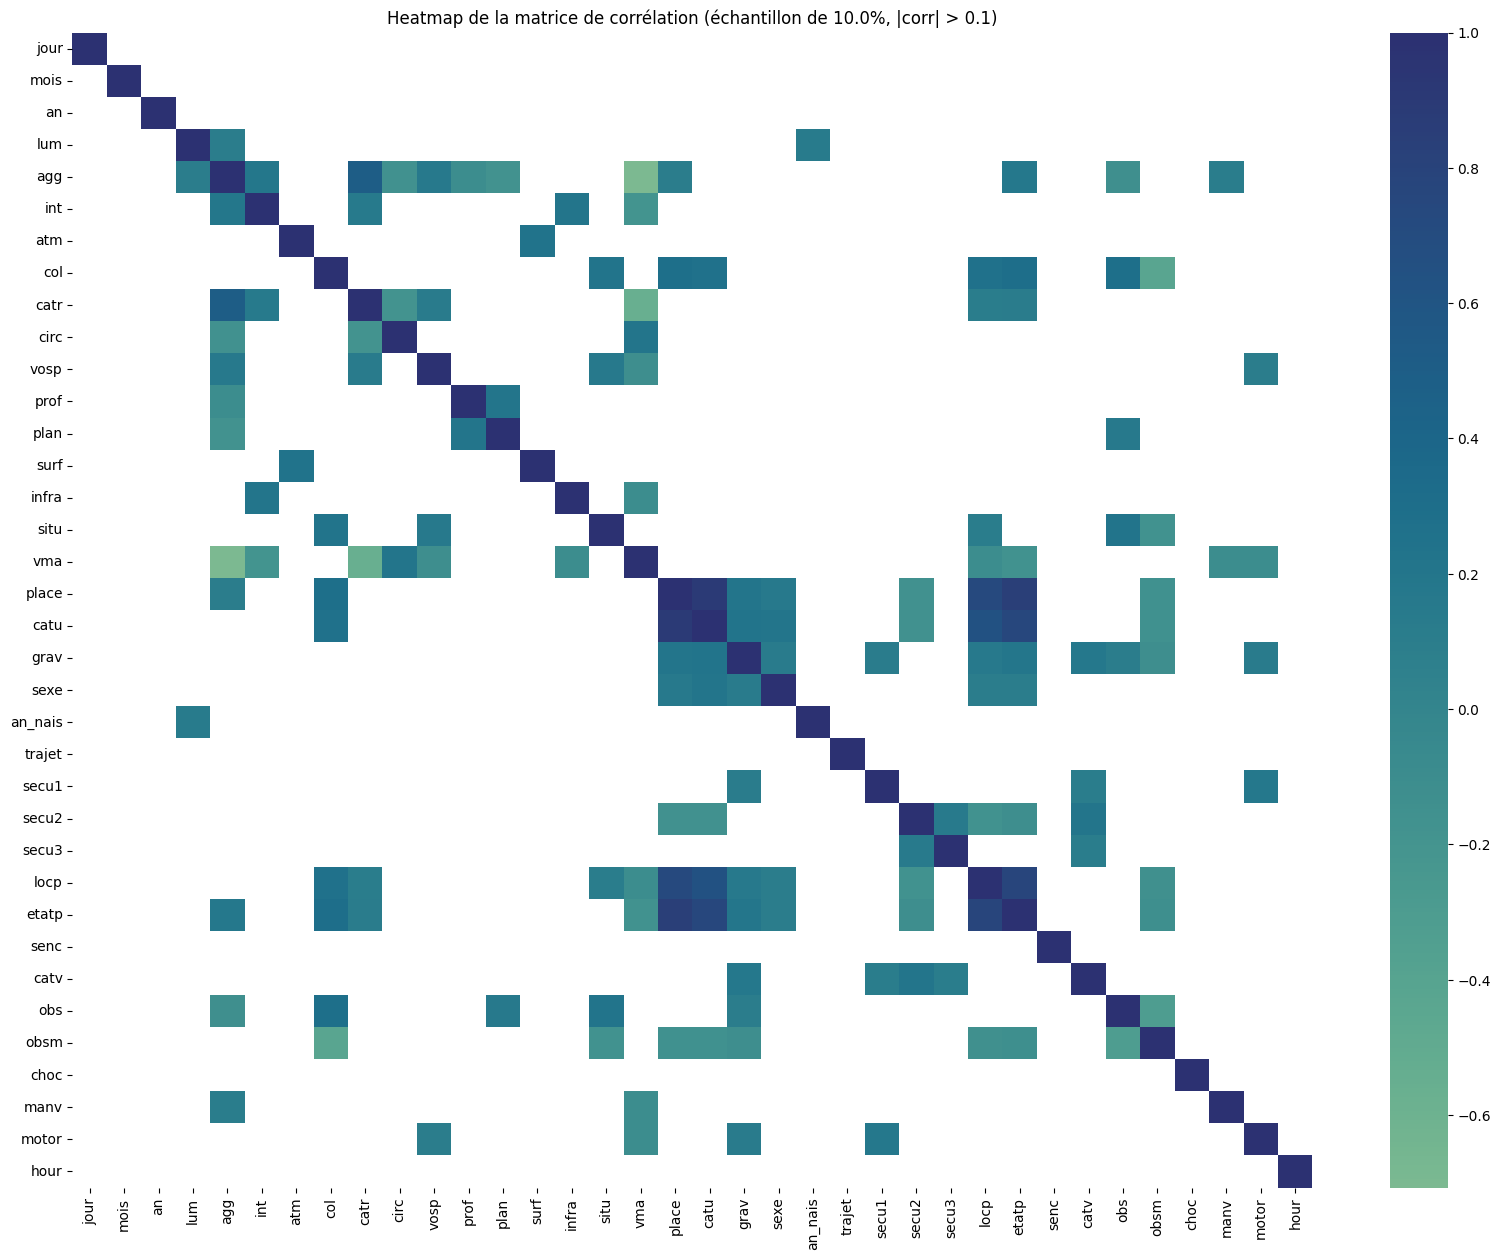

In [374]:
SAMPLE_SIZE = 0.1
CORR_TRESHOLD= 0.1


sampled_df = final_merged_df.sample(frac= SAMPLE_SIZE, random_state=RANDOM_STATE)
numeric_sampled_df = sampled_df.select_dtypes(include=[np.number])

cm = numeric_sampled_df.corr()

filtered_cm = cm[cm.abs() > CORR_TRESHOLD].dropna(how='all', axis=0).dropna(how='all', axis=1)


plt.figure(figsize=(20, 15))
sns.heatmap(filtered_cm, annot=False, cmap='crest', center=0)
plt.title(f'Heatmap de la matrice de corrélation (échantillon de {SAMPLE_SIZE*100}%, |corr| > {CORR_TRESHOLD})')
plt.show()

jour       0.005150
mois       0.001651
an         0.011676
lum        0.033481
agg        0.009375
int        0.008783
atm        0.001659
col        0.064768
catr       0.010618
circ       0.007988
vosp       0.002539
prof       0.016288
plan       0.030874
surf       0.022435
infra      0.009912
situ       0.039816
vma        0.005553
place      0.204330
catu       0.222104
grav       1.000000
sexe       0.127057
an_nais    0.074604
trajet     0.010738
secu1      0.119928
secu2      0.094593
secu3      0.035363
locp       0.165227
etatp      0.198222
senc       0.001155
catv       0.177345
obs        0.105359
obsm       0.119924
choc       0.029349
manv       0.062202
motor      0.128976
hour       0.021368
Name: grav, dtype: float64


C:\Users\remi\AppData\Local\Temp\ipykernel_2140\2974739451.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_corr_with_grav.values, y=filtered_corr_with_grav.index, palette='crest')


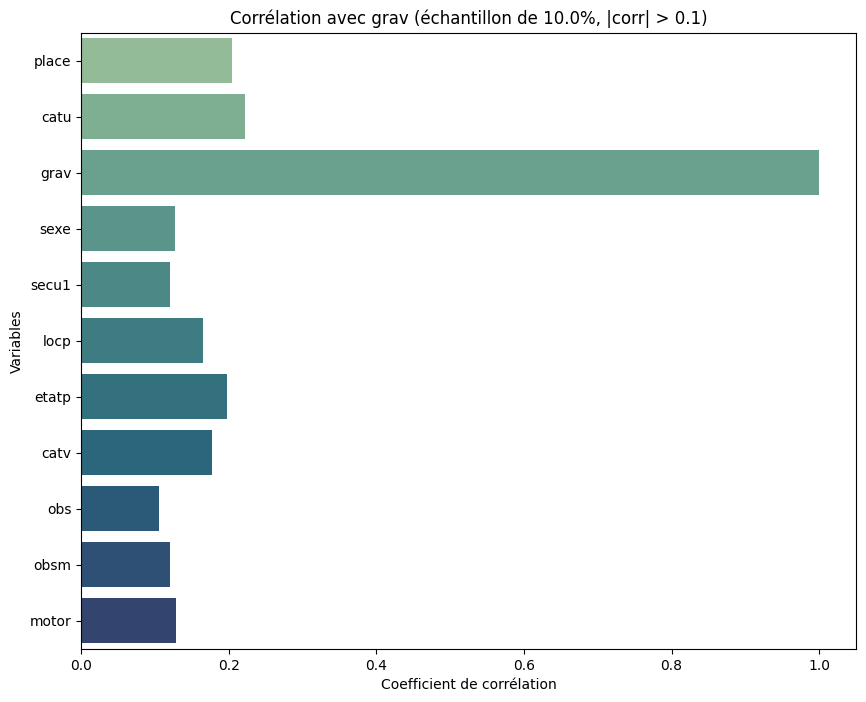

In [375]:
# Échantillonner 10% des données
sampled_df = final_merged_df.sample(frac=SAMPLE_SIZE, random_state=RANDOM_STATE)
# Sélectionner uniquement les colonnes numériques
numeric_sampled_df = sampled_df.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
cm = numeric_sampled_df.corr()

# Extraire les corrélations avec la variable cible 'grav'
corr_with_grav = cm['grav'].abs()

# Filtrer pour ne garder que les corrélations > 0.3
filtered_corr_with_grav = corr_with_grav[corr_with_grav > CORR_TRESHOLD]

# Afficher les corrélations filtrées sous forme de bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=filtered_corr_with_grav.values, y=filtered_corr_with_grav.index, palette='crest')
plt.title(f'Corrélation avec grav (échantillon de {SAMPLE_SIZE*100}%, |corr| > {CORR_TRESHOLD})')
plt.xlabel('Coefficient de corrélation')
plt.ylabel('Variables')
plt.show()

In [376]:
final_merged_df = encode_dataframe(final_merged_df)

In [377]:
# Convertir les objects en int64 et supprimer si besoin.

object_columns = final_merged_df.select_dtypes(include=['object']).columns
print(object_columns)
print(final_merged_df.shape)

columns_to_convert = list(object_columns)

for column in columns_to_convert:
    try:
        final_merged_df[column] = final_merged_df[column].astype('int64')
    except ValueError:
        final_merged_df = final_merged_df[pd.to_numeric(final_merged_df[column], errors='coerce').notnull()]
        final_merged_df[column] = final_merged_df[column].astype('int64')

print(final_merged_df.shape)
display(final_merged_df.columns)

Index(['nbv', 'pr', 'pr1'], dtype='object')
(494182, 387)
(374319, 387)


Index(['jour', 'mois', 'nbv', 'pr', 'pr1', 'vma', 'grav', 'an_nais', 'hour',
       'lum_1',
       ...
       'situ_2', 'situ_3', 'situ_4', 'situ_5', 'situ_6', 'situ_8', 'vosp_0',
       'vosp_1', 'vosp_2', 'vosp_3'],
      dtype='object', length=387)

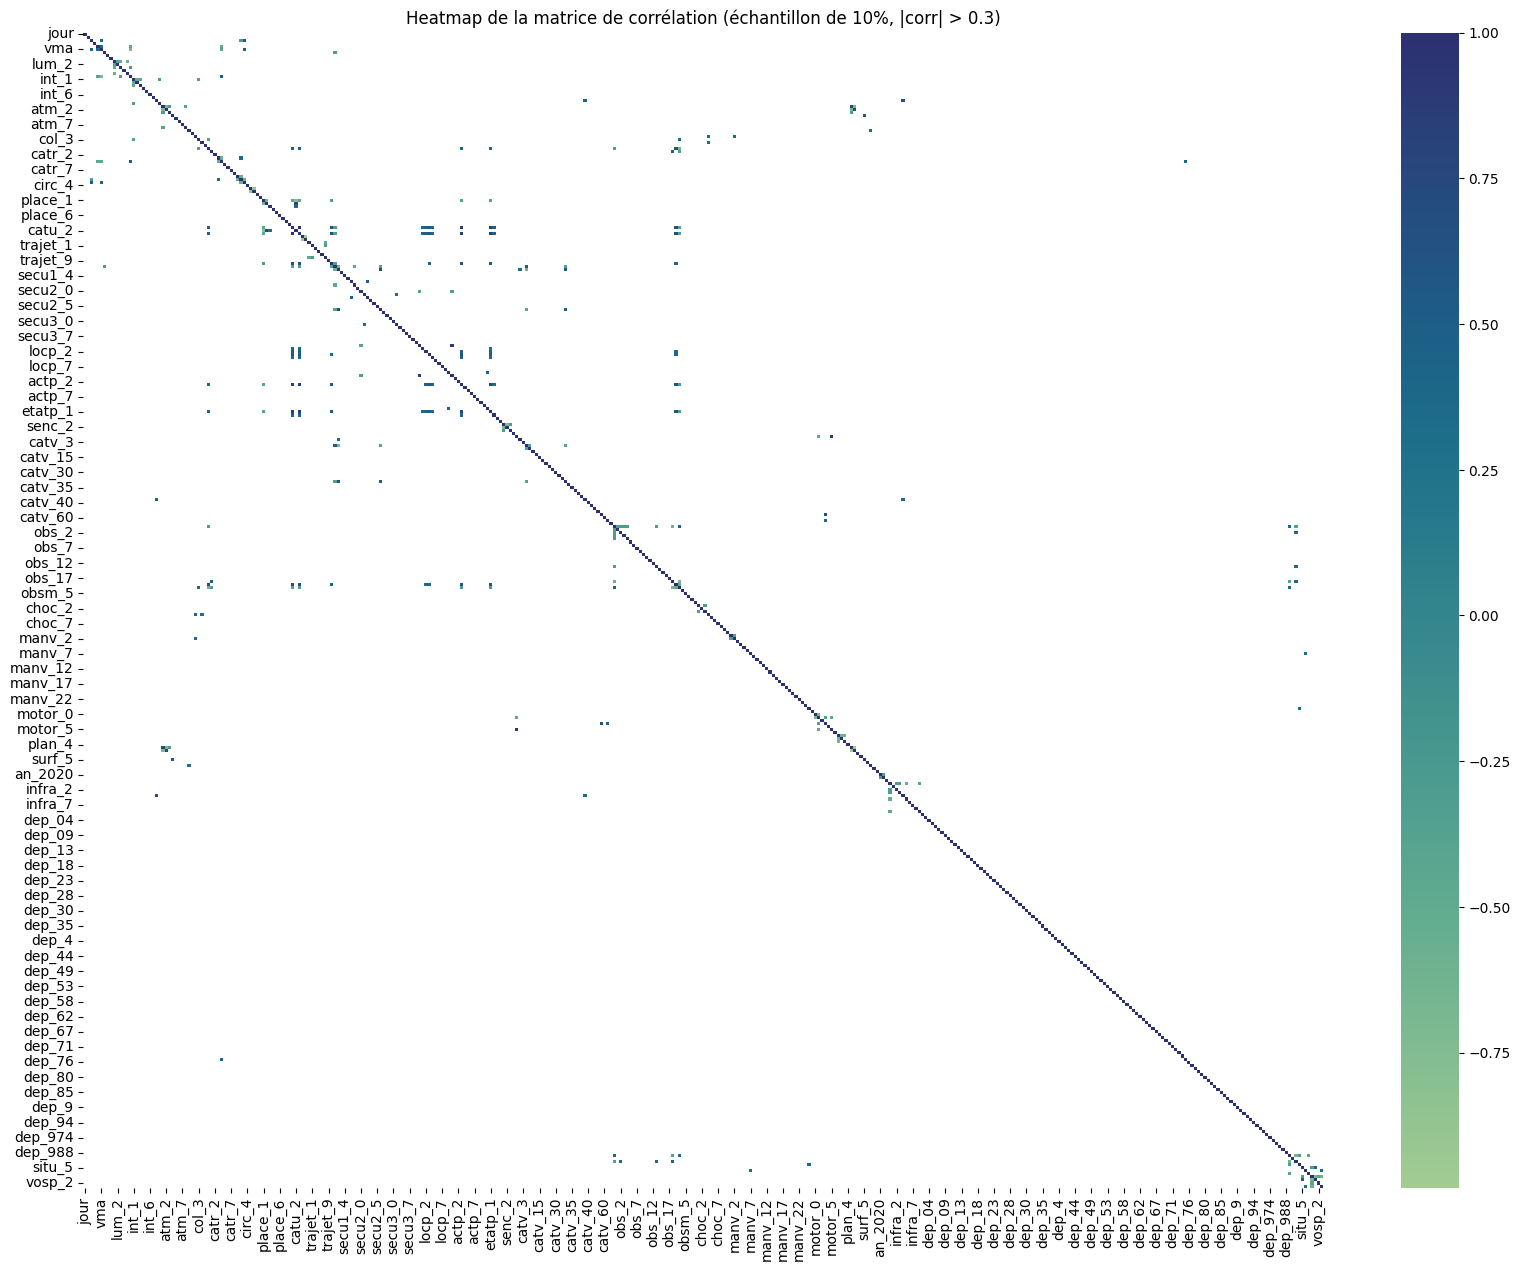

In [378]:

sampled_df = final_merged_df.sample(frac=0.1, random_state=RANDOM_STATE)

cm = sampled_df.corr()

filtered_cm = cm[cm.abs() > 0.3].dropna(how='all', axis=0).dropna(how='all', axis=1)

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_cm, annot=False, cmap='crest', center=0)
plt.title('Heatmap de la matrice de corrélation (échantillon de 10%, |corr| > 0.3)')
plt.show()

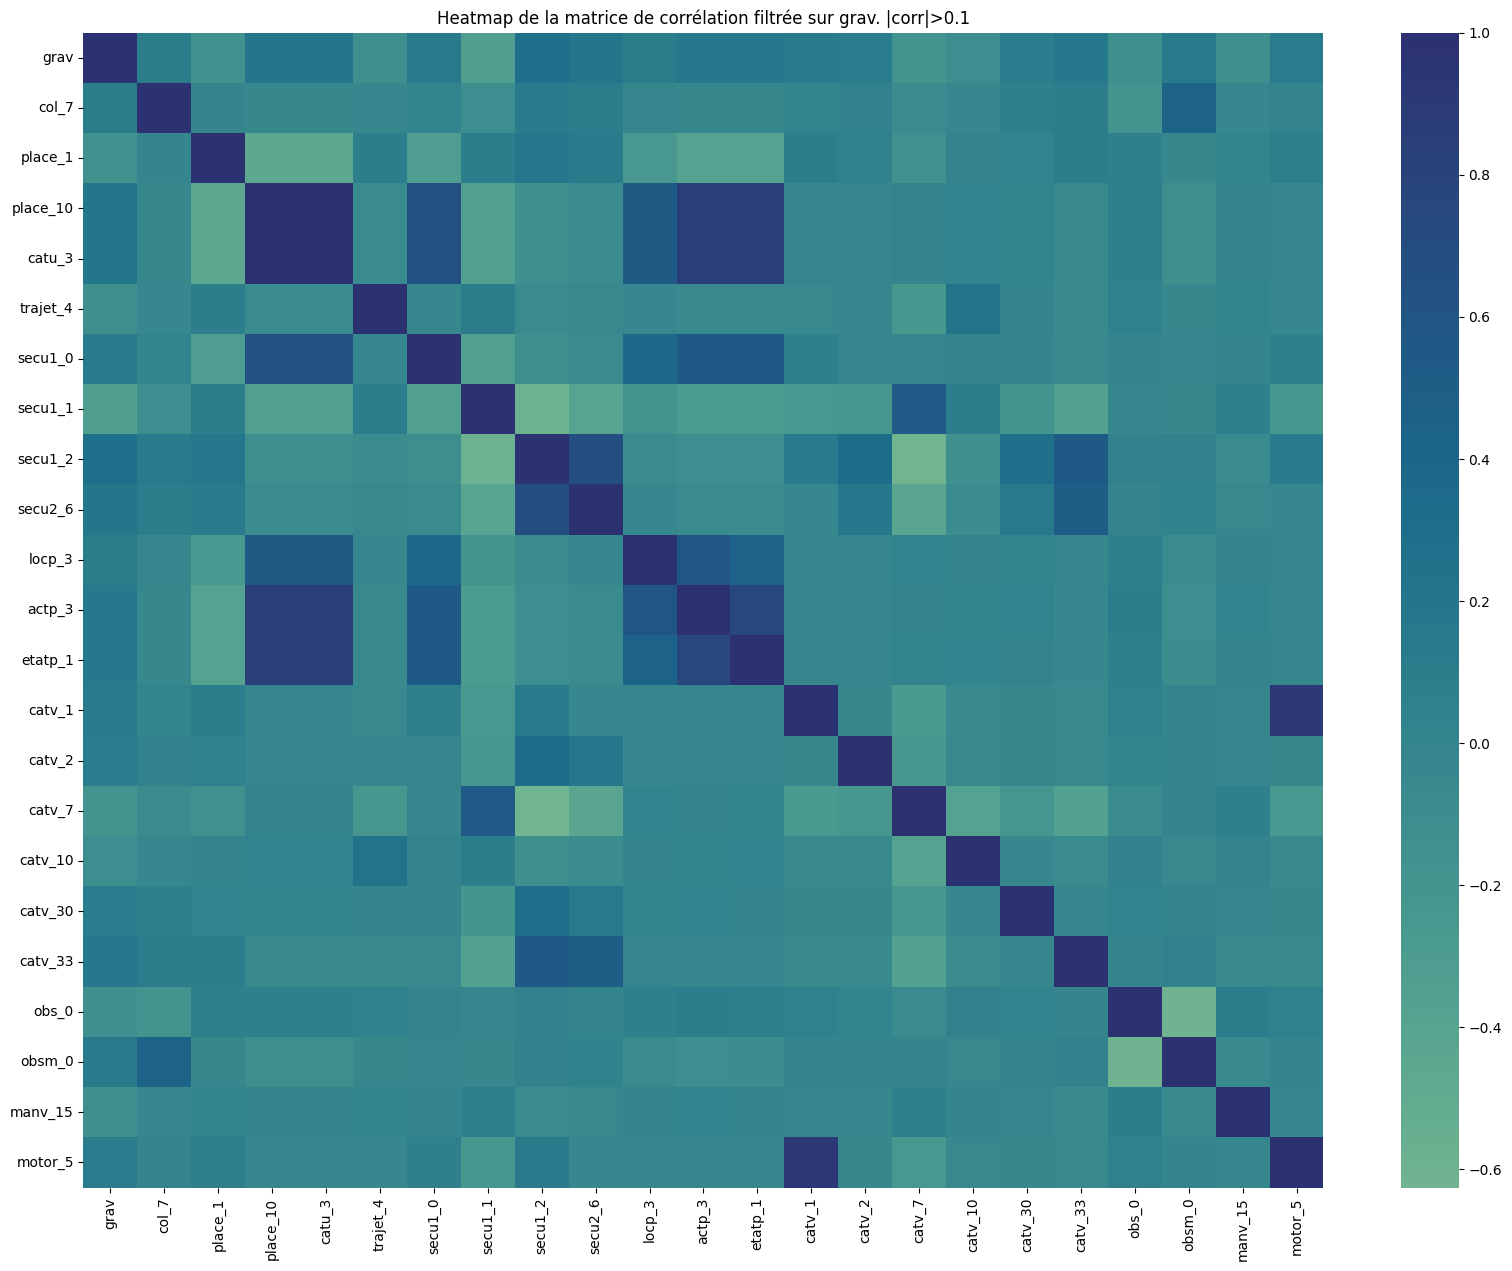

In [379]:
sampled_df = final_merged_df.sample(frac=0.1, random_state=RANDOM_STATE)

cm = sampled_df.corr()

target_corr = cm['grav'].abs()
selected_columns = target_corr[target_corr > 0.1].index
filtered_cm = cm.loc[selected_columns, selected_columns]

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_cm, annot=False, cmap='crest', center=0)
plt.title('Heatmap de la matrice de corrélation filtrée sur grav. |corr|>0.1')
plt.show()

In [380]:
PATH_TO_CSVS_PROCESSED = 'data/processed/data.csv'

final_merged_df.to_csv(PATH_TO_CSVS_PROCESSED)

In [381]:
X= final_merged_df.drop(columns=['grav'])
y= final_merged_df['grav']


dummy_columns = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'prof', 'place', 'catu', 'sexe', 
                     'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 
                     'obsm', 'choc', 'manv', 'motor', 'plan', 'surf','an','infra','dep','situ','vosp']
columns_to_scale = [col for col in X.columns if col not in dummy_columns]

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])